## 概要

ここ最近pymcを使ったベイズ推論のことをずっと考えています(2018年6月執筆当時)。pymc3を扱った本(http://amzn.asia/1TWcfTI)が先週発売されて買ってしまったのですが、まだ前のpymc本(http://amzn.asia/8CPISDp)を読み切っていなかったので急いで読み切りました。読み切った記念に一個面白そうなものがあったのでまとめました。

2群の平均値に差があるかどうか比べたいというよくある問いに対しては一般にt検定が使われます。当分散性が言えるとき（2郡の分散が同じである確信が持てるとき）はStudent's t-testを使います。分散については立山さんのノートを参考にどうぞ。

当分散性が言えないときは（自信がないときも保守的に）Welch's t-testを使います。余談ですが、どちらのt-testも平均値が正規分布に従うことを仮定しているので、その仮定が怪しいときはノンパラメトリックな検定を選びます。この辺りは誰かがコード付きでまとめてくれると信じてます。

このt検定ですが、ベイズ風のアレンジの論文が存在するようです。
**BEST**(Bayesian estimation supersedes the t-test)
というかっこいい名前です。
> Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.


2群それぞれを独立にt分布に従うと仮定し、それぞれ3つのパラメーター（平均、分散、外れ値）
を推論します。つまり、6つのパラメーターを推論します。ベイズ推論に落とし込むことで、2群それぞれの平均、分散、外れ値の解釈が容易になります。

## Bayesian estimation supersedes the t-test (BEST)
以下ではpymc3を用いてBESTを行います。まず、pymc3をpipでインストールしておきましょう：`pip install pymc3`

(参考)
- https://docs.pymc.io/notebooks/BEST.html
- 「Pythonで体験するベイズ推論」　Cameron Davidson-Pilon / 玉木 徹

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))


You can find the C code in this temporary file: C:\Users\user\AppData\Local\Temp\theano_compilation_error_rj2lh1wi


Exception: Compilation failed (return status=1): C:\Users\user\AppData\Local\Theano\compiledir_Windows-10-10.0.18362-SP0-Intel64_Family_6_Model_142_Stepping_9_GenuineIntel-3.7.6-64\lazylinker_ext\mod.cpp:1:0: sorry, unimplemented: 64-bit mode not compiled in.  #include <Python.h>.  . 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118c6b9b0>,
      dtype=object)

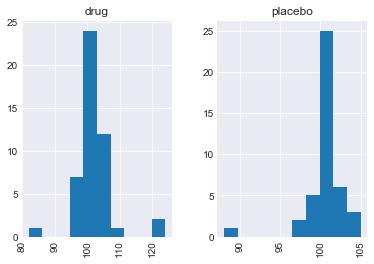

In [3]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group')

In [5]:
y.head()

,group,value
0,drug,101
1,drug,100
2,drug,102
3,drug,104
4,drug,102


In [6]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)

In [7]:
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

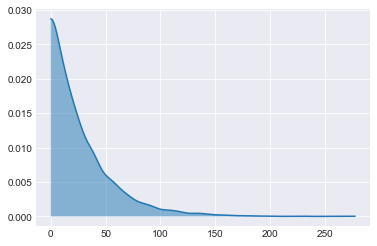

In [8]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), shade=0.5);

In [9]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [10]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [11]:
model

# 解釈

t分布は３つのパラメータ$\mu$, $\sigma$, $\nu$　がある。

- $\mu$ : 平均値。正規分布からサンプルする。
- $\sigma$ : 分散。一様分布からサンプルする。
- $\nu$ : 外れ値の観測しやすさ。指数分布を+1shiftした分布からサンプルする。

このt分布をgroup1, group2に対して推論する。

In [12]:
with model:
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/yasumizuyoshiaki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one_log__, group2_std_interval__, group1_std_interval__, group2_mean, group1_mean]
100%|██████████| 2500/2500 [00:06<00:00, 391.42it/s]


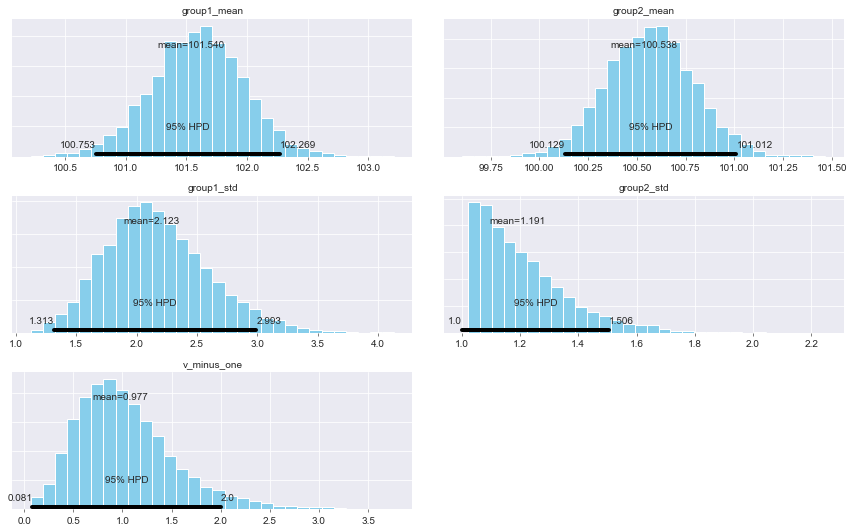

In [13]:
pm.plot_posterior(trace, varnames=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

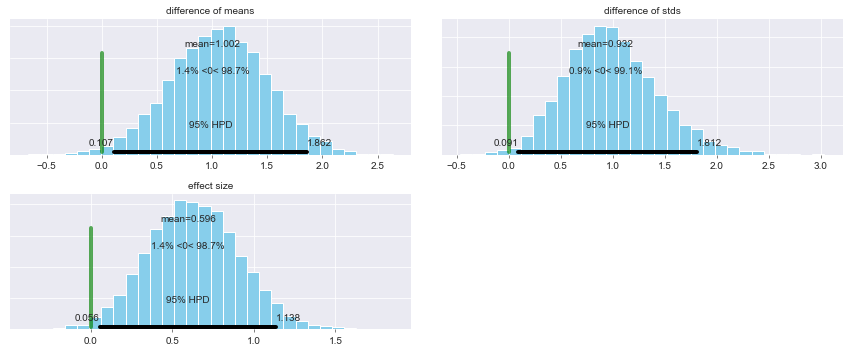

In [14]:
pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');

difference of meansは95%以上が0を超えているので、優位にgroup1のほうが高い事がわかる。

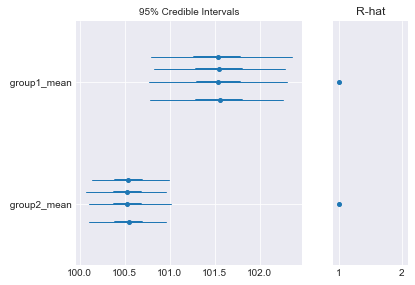

In [15]:
pm.forestplot(trace, varnames=['group1_mean',
                               'group2_mean']);

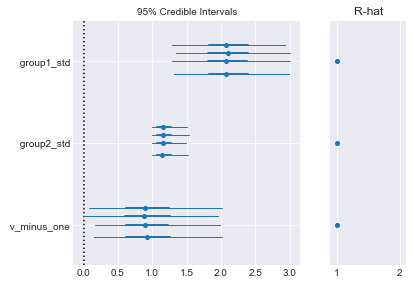

In [16]:
pm.forestplot(trace, varnames=['group1_std',
                               'group2_std',
                               'ν_minus_one']);

In [17]:
pm.summary(trace,varnames=['difference of means', 'difference of stds', 'effect size'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
difference of means,1.002127,0.44729,0.004676,0.107068,1.862148,6899.0,1.000230
difference of stds,0.932048,0.44503,0.005439,0.091474,1.812321,6332.0,0.999873
effect size,0.596257,0.28138,0.002947,0.056113,1.137876,6419.0,1.000327


In [37]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
group1_mean,101.540341,0.384866,0.003951,100.753486,102.268671,6679.0,1.000184
group2_mean,100.538214,0.225966,0.002765,100.128883,101.011508,6716.0,1.000200
group1_std,2.123269,0.435399,0.005634,1.312711,2.992706,5659.0,0.999986
group2_std,1.191221,0.159981,0.002027,1.000017,1.506498,6866.0,0.999932
ν_minus_one,0.977157,0.513533,0.006583,0.080532,1.999856,6040.0,0.999839
difference of means,1.002127,0.447290,0.004676,0.107068,1.862148,6899.0,1.000230
difference of stds,0.932048,0.445030,0.005439,0.091474,1.812321,6332.0,0.999873
effect size,0.596257,0.281380,0.002947,0.056113,1.137876,6419.0,1.000327


### 事後分布の生成

サンプルしたパラメーターを用いてt分布の事後分布を作成する。sample_ppcを使う。

https://docs.pymc.io/notebooks/posterior_predictive.html

In [59]:
ppc = pm.sample_ppc(trace, samples=50000, model=model)

100%|██████████| 50000/50000 [00:30<00:00, 1618.75it/s]


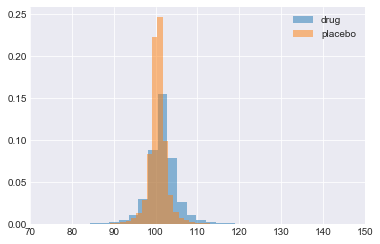

In [72]:
# sns.kdeplot(ppc['drug'], bw = 10)
# sns.kdeplot(ppc['placebo'], bw = 10)
plt.hist(ppc['drug'], bins=1000, density=True, label='drug', alpha=.5)
plt.hist(ppc['placebo'], bins=1000, density=True, label='placebo', alpha=.5)
plt.xlim(70,150)
plt.legend()

### 普通のT検定（分散が違うことがわかっているのてWelch）をやってみる。

In [21]:
y1

array([101, 100, 102, 104, 102,  97, 105, 105,  98, 101, 100, 123, 105,
       103, 100,  95, 102, 106, 109, 102,  82, 102, 100, 102, 102, 101,
       102, 102, 103, 103,  97,  97, 103, 101,  97, 104,  96, 103, 124,
       101, 101, 100, 101, 101, 104, 100, 101])

In [22]:
from scipy import stats

res = stats.ttest_ind(y1, y2, equal_var = False)
res

Ttest_indResult(statistic=1.622190457290228, pvalue=0.10975381983712831)

優位性示せず。


In [23]:
import seaborn as sns

/Users/yasumizuyoshiaki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/yasumizuyoshiaki/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


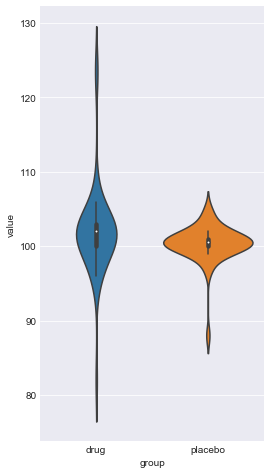

In [32]:
plt.figure(figsize=(4,8))
sns.violinplot(x='group', y='value', data=y)#, scale="count", inner="stick")